In [12]:

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [13]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_format="%Y-%m")

In [14]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [16]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

In [17]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [18]:
 # fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


array([[-0.05345677],
       [ 0.21997909],
       [-0.24725032],
       [ 0.17987904],
       [-0.37544248],
       [ 0.00199846],
       [-0.38765958],
       [-0.01865201],
       [ 0.08446718],
       [ 0.192081  ],
       [-0.96424586],
       [ 0.18192583],
       [-0.09522392],
       [ 0.12951764],
       [-0.3733127 ],
       [-0.38712946],
       [ 0.21035977],
       [-0.5517533 ],
       [ 0.17362382],
       [-0.4622615 ],
       [ 0.01051642],
       [-0.71159047],
       [ 0.16963379]], dtype=float32)

In [19]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Month=1, Predicted=284.680048, Expected=339.700000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Month=2, Predicted=360.371582, Expected=440.400000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Month=3, Predicted=361.883974, Expected=315.900000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Month=4, Predicted=384.320162, Expected=439.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Month=5, Predicted=341.993657, Expected=401.300000


/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Month=6, Predicted=449.406447, Expected=437.400000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Month=7, Predicted=420.923399, Expected=575.500000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Month=8, Predicted=467.172539, Expected=407.600000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Month=9, Predicted=463.012338, Expected=682.000000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Month=10, Predicted=512.953503, Expected=475.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array befor

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Month=11, Predicted=511.528982, Expected=581.300000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Month=12, Predicted=498.212649, Expected=646.900000


/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
/var/folders/vb/333j3hkd7x7bnylx5wz1wg140000gn/T/ipykernel_35506/4171057150.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Test RMSE: 100.839


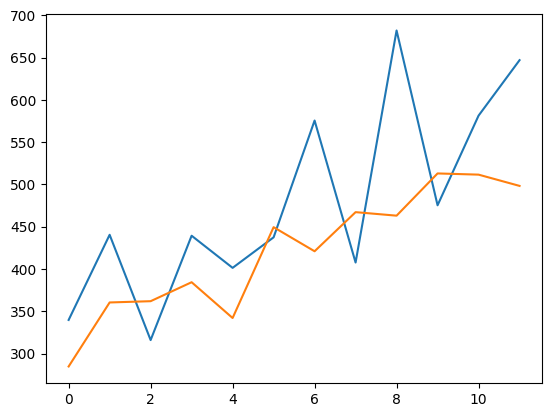

In [20]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()